<a href="https://colab.research.google.com/github/rahidt1/Papaya-Disease-Detection/blob/main/Papaya_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

Extracting ZIP file


In [13]:
local_zip = '/tmp/Papaya.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Creating Directoris for splitting Train & Test Data

In [14]:
try:
  os.mkdir('/tmp/papaya')
  os.mkdir('/tmp/papaya/training')
  os.mkdir('/tmp/papaya/testing')
  os.mkdir('/tmp/papaya/training/anthracnose')
  os.mkdir('/tmp/papaya/training/black_spot')
  os.mkdir('/tmp/papaya/training/paracoccus')
  os.mkdir('/tmp/papaya/training/phytophthora')
  os.mkdir('/tmp/papaya/training/powdery_mildew')
  os.mkdir('/tmp/papaya/training/ring_spot')
  os.mkdir('/tmp/papaya/testing/anthracnose')
  os.mkdir('/tmp/papaya/testing/black_spot')
  os.mkdir('/tmp/papaya/testing/paracoccus')
  os.mkdir('/tmp/papaya/testing/phytophthora')
  os.mkdir('/tmp/papaya/testing/powdery_mildew')
  os.mkdir('/tmp/papaya/testing/ring_spot')
except OSError:
    pass  


Function for splitting data

In [15]:

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


ANTHRACNOSE_SOURCE_DIR = "/tmp/Papaya_Disease/anthracnose/"
TRAINING_ANTHRACNOSE_DIR = "/tmp/papaya/training/anthracnose/"
TESTING_ANTHRACNOSE_DIR = "/tmp/papaya/testing/anthracnose/"

BLACK_SPOT_SOURCE_DIR = "/tmp/Papaya_Disease/black_spot/"
TRAINING_BLACK_SPOT_DIR = "/tmp/papaya/training/black_spot/"
TESTING_BLACK_SPOT_DIR = "/tmp/papaya/testing/black_spot/"

PARACOCCUS_SOURCE_DIR = "/tmp/Papaya_Disease/paracoccus/"
TRAINING_PARACOCCUS_DIR = "/tmp/papaya/training/paracoccus/"
TESTING_PARACOCCUS_DIR = "/tmp/papaya/testing/paracoccus/"

PHYTOPHTHORA_SOURCE_DIR = "/tmp/Papaya_Disease/phytophthora/"
TRAINING_PHYTOPHTHORA_DIR = "/tmp/papaya/training/phytophthora/"
TESTING_PHYTOPHTHORA_DIR = "/tmp/papaya/testing/phytophthora/"

POWDERY_MILDEW_SOURCE_DIR = "/tmp/Papaya_Disease/powdery_mildew/"
TRAINING_POWDERY_MILDEW_DIR = "/tmp/papaya/training/powdery_mildew/"
TESTING_POWDERY_MILDEW_DIR = "/tmp/papaya/testing/powdery_mildew/"

RING_SPOT_SOURCE_DIR = "/tmp/Papaya_Disease/ring_spot/"
TRAINING_RING_SPOT_DIR = "/tmp/papaya/training/ring_spot/"
TESTING_RING_SPOT_DIR = "/tmp/papaya/testing/ring_spot/"

split_size = .9
split_data(ANTHRACNOSE_SOURCE_DIR, TRAINING_ANTHRACNOSE_DIR, TESTING_ANTHRACNOSE_DIR, split_size)
split_data(BLACK_SPOT_SOURCE_DIR, TRAINING_BLACK_SPOT_DIR, TESTING_BLACK_SPOT_DIR, split_size)
split_data(PARACOCCUS_SOURCE_DIR, TRAINING_PARACOCCUS_DIR, TESTING_PARACOCCUS_DIR, split_size)
split_data(PHYTOPHTHORA_SOURCE_DIR, TRAINING_PHYTOPHTHORA_DIR, TESTING_PHYTOPHTHORA_DIR, split_size)
split_data(POWDERY_MILDEW_SOURCE_DIR, TRAINING_POWDERY_MILDEW_DIR, TESTING_POWDERY_MILDEW_DIR, split_size)
split_data(RING_SPOT_SOURCE_DIR, TRAINING_RING_SPOT_DIR, TESTING_RING_SPOT_DIR, split_size)

Download Inception_v3 model, remove Fully connected layer of the model and make the model non-trainable for our data 

In [16]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
#pre_trained_model.summary()

--2021-03-13 05:32:19--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   140MB/s    in 0.6s    

2021-03-13 05:32:19 (140 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Set 'mixed7' as last layer, after that we include our own layers

In [17]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


Callback function if we want to use early stopping

In [18]:

# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True
     

In [19]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (6, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

#model.summary()

In [20]:
TRAINING_DIR = "/tmp/papaya/training/"
VALIDATION_DIR = "/tmp/papaya/testing/"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))


validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=10,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

Found 223 images belonging to 6 classes.
Found 92 images belonging to 6 classes.


In [21]:
callbacks = myCallback()
history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
23/23 [==============================] - 7s 175ms/step - loss: 2.0657 - accuracy: 0.3314 - val_loss: 0.6252 - val_accuracy: 0.8152
Epoch 2/15
23/23 [==============================] - 2s 104ms/step - loss: 0.7530 - accuracy: 0.7686 - val_loss: 0.4087 - val_accuracy: 0.8587
Epoch 3/15
23/23 [==============================] - 2s 104ms/step - loss: 0.5032 - accuracy: 0.8232 - val_loss: 0.2445 - val_accuracy: 0.9022
Epoch 4/15
23/23 [==============================] - 2s 105ms/step - loss: 0.3972 - accuracy: 0.8711 - val_loss: 0.2965 - val_accuracy: 0.9239
Epoch 5/15
23/23 [==============================] - 2s 105ms/step - loss: 0.3496 - accuracy: 0.8970 - val_loss: 0.1311 - val_accuracy: 0.9457
Epoch 6/15
23/23 [==============================] - 2s 105ms/step - loss: 0.2936 - accuracy: 0.8842 - val_loss: 0.1964 - val_accuracy: 0.9457
Epoch 7/15
23/23 [==============================] - 2s 104ms/step - loss: 0.2613 - accuracy: 0.8930 - val_loss: 0.0942 - val_accuracy: 0.9891
Epoch 

<Figure size 432x288 with 0 Axes>

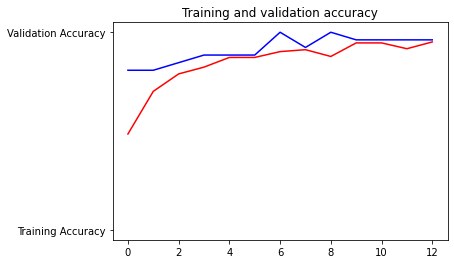

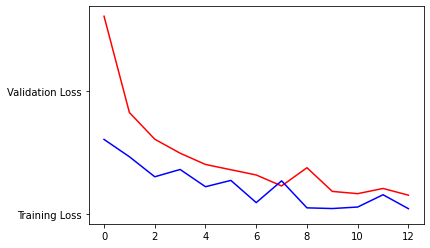

<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()